In [8]:
# Imports
import numpy
import pandas
import sklearn
import sklearn.dummy
import sklearn.ensemble

In [9]:
# Matplotlib setup
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

In [17]:
# Load justice-centered SCDB data
scdb_data = pandas.read_csv("data/SCDB_2013_01_justiceCentered_Citation.csv")

## Disposition outcoming coding

  In the section below, we transform the SCDB vote and caseDisposition variables into an outcome variable indicating whether the case overall and each Justice has affirmed or reverse.
  
  * vote: [http://scdb.wustl.edu/documentation.php?var=vote#norms](http://scdb.wustl.edu/documentation.php?var=vote#norms)
  * caseDisposition: [http://scdb.wustl.edu/documentation.php?var=caseDisposition#norms](http://scdb.wustl.edu/documentation.php?var=caseDisposition#norms)

In [51]:
"""
Setup the outcome map.

Rows correspond to vote types.  Columns correspond to disposition types.

Element values correspond to:
 * -1: no precedential issued opinion or uncodable, i.e., DIGs
 * 0: affirm, i.e., no change in precedent
 * 1: reverse, i.e., change in precent
"""
outcome_map = pandas.DataFrame([[-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 1, 0, 0, 0, 1, 0, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, 0, 1, 1, 1, 0, 1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
               [-1, 0, 0, 0, -1, 0, -1, -1, -1, -1, -1]])
outcome_map.columns = range(1, 12)
outcome_map.index = range(1, 9)

def get_outcome(vote, disposition):
    """
    Return the outcome code.
    """
    if pandas.isnull(vote) or pandas.isnull(disposition):
        return -1
    
    return outcome_map.loc[int(vote), int(disposition)]

In [56]:
# Map the case-level disposition outcome 
scdb_data.loc[:, "case_outcome_disposition"] = outcome_map.loc[1, scdb_data.loc[:, "caseDisposition"]].values

# Map the justice-level disposition outcome
scdb_data.loc[:, "justice_outcome_disposition"] = scdb_data.loc[:, ("vote", "caseDisposition")] \
    .apply(lambda row: get_outcome(row["vote"], row["caseDisposition"]), axis=1)

## Running a simulation

  In the section below, we define methods that handle the execution and analysis of simulations.  Simulations are based around the following concepts:
  
  * __prediction methods__: prediction methods take historical data and determine, for each term-justice,  what prediction to make.

In [268]:
def predict_court_case_rate(historical_data, justice_list):
    """
    Prediction method based on the entire Court case-level historical reversal rate.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param justice_list: list of Justices to generate predictions for

    :return: dictionary containing a prediction score for reversal for each Justice
    """
    
    # Calculate the rate
    counts = historical_data.loc[:, "case_outcome_disposition"].value_counts()
    rate = float(counts.ix[1]) / (counts.ix[0] + counts.ix[1])
    
    # Create return dictionary
    prediction_map = dict([(justice, rate) for justice in justice_list])
    
    return prediction_map

def predict_court_justice_rate(historical_data, justice_list):
    """
    Prediction method based on the entire Court justice-level historical reversal rate.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param justice_list: list of Justices to generate predictions for

    :return: dictionary containing a prediction score for reversal for each Justice
    """
    
    # Calculate the rate
    counts = historical_data.loc[:, "justice_outcome_disposition"].value_counts()
    rate = float(counts.ix[1]) / (counts.ix[0] + counts.ix[1])
    
    # Create return dictionary
    prediction_map = dict([(justice, rate) for justice in justice_list])
    
    return prediction_map

def predict_justice_rate(historical_data, justice_list):
    """
    Prediction method based on the per-Justice historical reversal rate.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param justice_list: list of Justices to generate predictions for

    :return: dictionary containing a prediction score for reversal for each Justice
    """
    
    # Create return dictionary
    prediction_map = dict([(justice, numpy.nan) for justice in justice_list])
    
    # Calculate the rate
    for justice_id,  justice_data in historical_data.groupby('justice'):
        # Check justice ID
        if justice_id not in justice_list:
            continue
        
        # Else, get the rate.
        counts = justice_data.loc[:, "justice_outcome_disposition"].value_counts()
        rate = float(counts.ix[1]) / (counts.ix[0] + counts.ix[1])
        prediction_map[justice_id] = rate
        
    # In some cases, we have a new Justice without historical data.  Fill their value with the overall rate.
    counts = historical_data.loc[:, "justice_outcome_disposition"].value_counts()
    rate = float(counts.ix[1]) / (counts.ix[0] + counts.ix[1])
    
    for justice in justice_list:
        if pandas.isnull(prediction_map[justice]):
            prediction_map[justice] = rate
    
    return prediction_map


def predict_justice_last_rate(historical_data, justice_list, last_terms=1):
    """
    Prediction method based on the per-Justice historical reversal rate.
    
    :param historical_data: SCDB DataFrame to use for out-of-sample calculationi; must be a subset of SCDB justice-centered 
      data known up to point in time
    :param justice_list: list of Justices to generate predictions for
    :param last_terms: number of recent terms to use for rate estimate

    :return: dictionary containing a prediction score for reversal for each Justice
    """
    
    # Create return dictionary
    prediction_map = dict([(justice, numpy.nan) for justice in justice_list])
    
    # Calculate the rate
    for justice_id,  justice_data in historical_data.groupby('justice'):
        # Check justice ID
        if justice_id not in justice_list:
            continue
        
        # Else, get the rate.
        max_term = justice_data["term"].max()
        counts = justice_data.loc[justice_data["term"] >= (max_term-last_terms+1), "justice_outcome_disposition"].value_counts()
        rate = float(counts.ix[1]) / (counts.ix[0] + counts.ix[1])
        prediction_map[justice_id] = rate
        
    # In some cases, we have a new Justice without historical data.  Fill their value with the overall rate.
    counts = historical_data.loc[:, "justice_outcome_disposition"].value_counts()
    rate = float(counts.ix[1]) / (counts.ix[0] + counts.ix[1])
    
    for justice in justice_list:
        if pandas.isnull(prediction_map[justice]):
            prediction_map[justice] = rate
    
    return prediction_map

def run_simulation(simulation_data, term_list,  prediction_method, score_method="binary"):
    """
    This method defines the simulation driver.
    
    :param simulation_data: SCDB DataFrame to use for simulation; must be a subset of SCDB justice-centered data
    :param term_list: list of terms to simulate, e.g., [2000, 2001, 2002]
    :param prediction_method: method that takes historical data and indicates, by justice,  predictions for term
    :param score_method: "binary" or "stratified"; binary maps to score >= 0.5, stratified maps to score <= random
    :return: copy of simulation_data with additional columns representing predictions
    """
    
    # Initialize predictions
    return_data = simulation_data.copy()
    return_data.loc[:, "prediction"] = numpy.nan
    return_data.loc[:, "prediction_score"] = numpy.nan

    # Iterate over all terms
    for term in term_list:
        # Get indices for dockets to predict and use for historical data
        before_term_index = scdb_data.loc[:, "term"] < term
        current_term_index = simulation_data.loc[:, "term"] == term
        
        # Get the list of justices
        term_justices = sorted(simulation_data.loc[current_term_index, "justice"].unique().tolist())
        
        # Get the prediction map
        prediction_map = prediction_method(simulation_data.loc[before_term_index, :], term_justices)
        
        # Get the predictions
        return_data.loc[current_term_index, "prediction_score"] =  [prediction_map[j] for j in simulation_data.loc[current_term_index, "justice"].values]
        
        # Support both most_frequent and stratified approaches
        if score_method == "binary":
            return_data.loc[current_term_index, "prediction"] = (return_data.loc[current_term_index, "prediction_score"] >= 0.5).apply(int)
        elif score_method == "stratified":
            return_data.loc[current_term_index, "prediction"] = (return_data.loc[current_term_index, "prediction_score"] >= numpy.random.random(return_data.loc[current_term_index].shape[0])).apply(int)
        else:
            raise NotImplementedError
    
    
    # Get the return range and return
    term_index = return_data.loc[:, "term"].isin(term_list)
    return return_data.loc[term_index, :]

In [269]:
# Set parameters
start_term = 1953
end_term = 2013

## Predicting case outcomes with court reversal rate

  In the simulation below, we demonstrate the performance of the baseline model to predict case outcome based solely on historical court reversal rate.
  
  The results indicate an accuracy of 63.72% with a frequency-weighted F1 score of 49.6%.

In [270]:
# Run simulation for simplest model
print("predict_court_case_rate")
output_data = run_simulation(scdb_data, range(start_term, end_term), predict_court_case_rate)

# Analyze results
print(sklearn.metrics.classification_report(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))

# Get accuracy over time
output_data.loc[:, "correct"] = (output_data["case_outcome_disposition"].fillna(-1) == output_data["prediction"].fillna(-1))
court_case_accuracy_by_year = output_data.groupby("term")["correct"].mean()


predict_court_case_rate
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00      4573
        0.0       0.00      0.00      0.00     20445
        1.0       0.64      1.00      0.78     43946

avg / total       0.41      0.64      0.50     68964

[[    0     0  4573]
 [    0     0 20445]
 [    0     0 43946]]
0.637231019082
0.496036743683


## Predicting case outcomes with Justice reversal rate

  In the simulation below, we demonstrate the performance of the baseline model to predict case outcome based solely on historical Justice reversal rate.
  
  The results are identical to the simulation above, and indicate an accuracy of 63.72% with a frequency-weighted F1 score of 49.6%.

In [271]:
# Run simulation for simplest model
print("predict_court_justice_rate")
output_data = run_simulation(scdb_data, range(start_term, end_term), predict_court_justice_rate)

# Analyze results
print(sklearn.metrics.classification_report(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))


# Get accuracy over time
output_data.loc[:, "correct"] = (output_data["case_outcome_disposition"].fillna(-1) == output_data["prediction"].fillna(-1))
court_justice_accuracy_by_year = output_data.groupby("term")["correct"].mean()


predict_court_justice_rate
             precision    recall  f1-score   support

       -1.0       0.00      0.00      0.00      4573
        0.0       0.00      0.00      0.00     20445
        1.0       0.64      1.00      0.78     43946

avg / total       0.41      0.64      0.50     68964

[[    0     0  4573]
 [    0     0 20445]
 [    0     0 43946]]
0.637231019082
0.496036743683


## Predicting Justice outcomes with Justice reversal rate

  In the simulation below, we demonstrate the performance of the baseline model to predict Justice outcome based solely on historical Justice reversal rate.
  
  The results indicate an accuracy of 57.1% with a frequency-weighted F1 score of 49.7%.

In [272]:
# Run simulation for simplest model
print("predict_justice_rate")
output_data = run_simulation(scdb_data, range(start_term, end_term), predict_justice_rate)

# Analyze results
print(sklearn.metrics.classification_report(output_data["justice_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data["justice_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data["justice_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))

# Get accuracy over time
output_data.loc[:, "correct"] = (output_data["justice_outcome_disposition"].fillna(-1) == output_data["prediction"].fillna(-1))
justice_accuracy_by_year = output_data.groupby("term")["correct"].mean()


predict_justice_rate
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      6398
          0       0.31      0.00      0.00     23187
          1       0.57      1.00      0.73     39379

avg / total       0.43      0.57      0.42     68964

[[    0     6  6392]
 [    0    30 23157]
 [    0    62 39317]]
0.570544051969
0.496702114612


## Predicting Justice outcomes with trailing Justice reversal rate

  In the simulation below, we demonstrate the performance of the baseline model to predict Justice outcome based solely on historical Justice reversal rate over the last one term.
  
  The results indicate an accuracy of 56.7% with a frequency-weighted F1 score of 52.0%.

In [273]:
# Run simulation for simplest model
print("predict_justice_last_rate")
output_data = run_simulation(scdb_data, range(start_term, end_term), predict_justice_last_rate)

# Analyze results
print(sklearn.metrics.classification_report(output_data["justice_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.confusion_matrix(output_data["justice_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.accuracy_score(output_data["justice_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))
print(sklearn.metrics.f1_score(output_data["case_outcome_disposition"].fillna(-1),
                                      output_data["prediction"].fillna(-1)))

# Get accuracy over time
output_data.loc[:, "correct"] = (output_data["justice_outcome_disposition"].fillna(-1) == output_data["prediction"].fillna(-1))
justice_last_accuracy_by_year = output_data.groupby("term")["correct"].mean()

predict_justice_last_rate
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00      6398
          0       0.42      0.10      0.16     23187
          1       0.58      0.94      0.72     39379

avg / total       0.47      0.57      0.46     68964

[[    0   521  5877]
 [    0  2226 20961]
 [    0  2519 36860]]
0.566759468708
0.520050061416


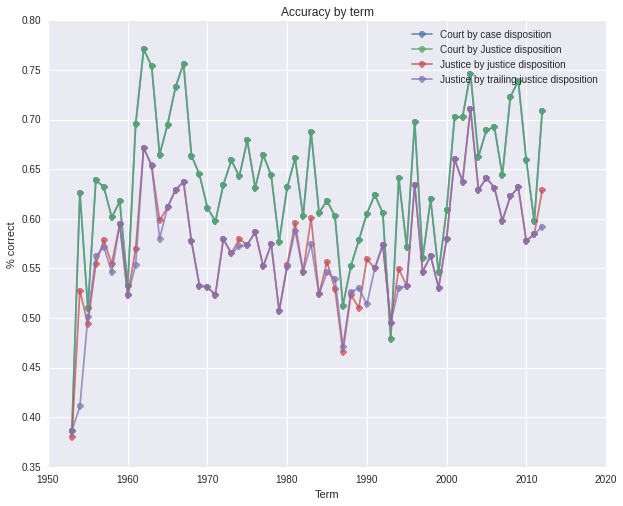

In [275]:
# Plot all accuracies
f = plt.figure(figsize=(10, 8))
plt.plot(court_case_accuracy_by_year.index, court_case_accuracy_by_year,
         marker='o', alpha=0.75)
plt.plot(court_justice_accuracy_by_year.index, court_justice_accuracy_by_year,
         marker='o', alpha=0.75)
plt.plot(justice_accuracy_by_year.index, justice_accuracy_by_year,
         marker='o', alpha=0.75)
plt.plot(justice_last_accuracy_by_year.index, justice_last_accuracy_by_year,
         marker='o', alpha=0.75)

plt.title("Accuracy by term")
plt.xlabel("Term")
plt.ylabel("% correct")
plt.legend(("Court by case disposition", "Court by Justice disposition",
            "Justice by justice disposition", "Justice by trailing justice disposition"))

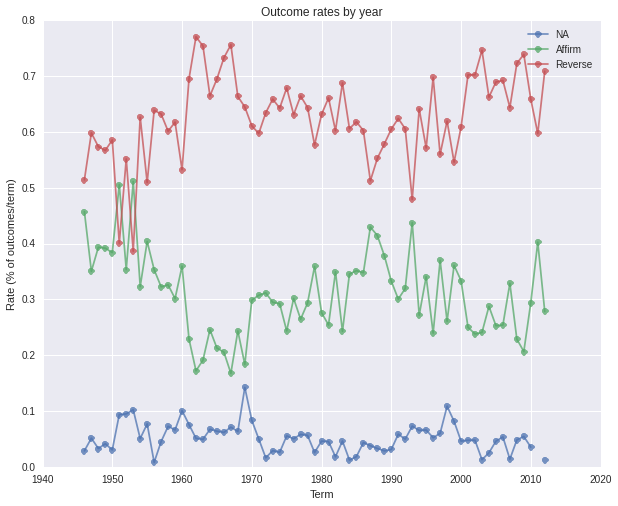

In [264]:
# Plot case disposition rate by term
rate_data = scdb_data.groupby("term")["case_outcome_disposition"].value_counts(normalize=True, sort=True).unstack()
f = plt.figure(figsize=(10, 8))
plt.plot(rate_data.index, rate_data, marker="o", alpha=0.75)
plt.title("Outcome rates by year")
plt.xlabel("Term")
plt.ylabel("Rate (% of outcomes/term)")
plt.legend(("NA", "Affirm", "Reverse"))